In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')
import types
import pkg_resources
import pyodbc
import scipy.stats
import matplotlib.ticker as mtick

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))
    
from IPython.display import HTML

seaborn==0.11.2
scipy==1.7.1
pyodbc==4.0.0-unsupported
pandas==1.3.4
numpy==1.20.3
matplotlib==3.4.3


In [2]:
##Define Data Retrevial Functions

##Get summary_coc data only
def write_query_summary_coc(return_fields, filter_args):
    summary_coc = "[dbo].[summary_coc]"
    channel_summary = "[dbo].[channel_summary]"
    channel_readings = "[dbo].[channel_readings]"
    
    
    if return_fields == '*':
        query = "Select * from "+summary_coc
    else:
        query = "Select"
        for return_field in return_fields:
            query+=" ["+return_field+"],"
        query = query[:-1]
        query+=" from "+summary_coc
        
    if filter_args != {}:
        query+=" where "
        for arg in filter_args:
            filter_field, comparator, filter_values = filter_args[arg]
            filter_field = summary_coc+"."+"["+filter_field+"]" 
            if comparator in ['=','!=', '>', '<', '>=', '<=']:
                query+=filter_field+" "+comparator+" '"+filter_values+"' and "
            elif comparator in ['like', 'not like']:
                query+=filter_field+" "+comparator+" '%"+filter_values+"%' and "
            elif comparator in ['in', 'not in']:
                query+=filter_field+" "+comparator+" ("+", ".join("'"+str(value)+"'" for value in filter_values)+") and "
            elif comparator in ['like list']:
                query+="("
                for item in filter_values:
                    query+=filter_field+" like '%"+item+"%' or "
                query=query[:-4]
                query+=") and "
        query=query[:-5]
    print(query)
    return query

##Get summary_coc & channel_summary data
def write_query_all_summary(channels, return_fields, filter_args):
    summary_coc = "[dbo].[summary_coc]"
    channel_summary = "[dbo].[channel_summary]"
        
    if return_fields == '*':
        query = "Select * from "+summary_coc
        query+=" LEFT JOIN "+channel_summary+" On "+summary_coc+".[Test Guid]="+channel_summary+".[Test Guid]"
    else:
        query = "Select"
        for return_field in return_fields:
            query+=" ["+return_field+"],"
        query = query[:-1]
        query+=" from "+summary_coc
        
    if filter_args != {}:
        query+=" where "
        for arg in filter_args:
            filter_field, comparator, filter_values = filter_args[arg]
            filter_field = summary_coc+"."+"["+filter_field+"]" 
            if comparator in ['=','!=', '>', '<', '>=', '<=']:
                query+=filter_field+" "+comparator+" '"+filter_values+"' and "
            elif comparator in ['like', 'not like']:
                query+=filter_field+" "+comparator+" '%"+filter_values+"%' and "
            elif comparator in ['in', 'not in']:
                query+=filter_field+" "+comparator+" ("+", ".join("'"+str(value)+"'" for value in filter_values)+") and "
            elif comparator in ['like list']:
                query+="("
                for item in filter_values:
                    query+=filter_field+" like '%"+item+"%' or "
                query=query[:-4]
                query+=") and "
        query=query[:-5]
    query+=" and ("
    for channel in channels:        
        query+="[dbo].[channel_summary].[Channel]='"+channel+"'or "
    query=query[:-3]
    query+=")"
    print(query)
    return query

##Get summary_coc & channel_summary data & channel_readings
def write_query_all_tables(channels, datablocks, return_fields, filter_args):
    summary_coc = "[dbo].[summary_coc]"
    channel_summary = "[dbo].[channel_summary]"
    channel_readings = "[dbo].[channel_readings]"
    
    if return_fields == '*':
        query = "Select * from "+summary_coc
        query+=" LEFT JOIN "+channel_summary+" On "+summary_coc+".[Test Guid]="+channel_summary+".[Test Guid]"
        query+=" LEFT JOIN "+channel_readings+" On "+channel_summary+".[Target Result Guid]="+channel_readings+".[Target Result Guid]"
    else:
        query = "Select"
        for return_field in return_fields:
            query+=" ["+return_field+"],"
        query = query[:-1]
        query+=" from "+summary_coc
        
    if filter_args != {}:
        query+=" where "
        for arg in filter_args:
            filter_field, comparator, filter_values = filter_args[arg]
            filter_field = summary_coc+"."+"["+filter_field+"]" 
            if comparator in ['=','!=', '>', '<', '>=', '<=']:
                query+=filter_field+" "+comparator+" '"+filter_values+"' and "
            elif comparator in ['like', 'not like']:
                query+=filter_field+" "+comparator+" '%"+filter_values+"%' and "
            elif comparator in ['in', 'not in']:
                query+=filter_field+" "+comparator+" ("+", ".join("'"+str(value)+"'" for value in filter_values)+") and "
            elif comparator in ['like list']:
                query+="("
                for item in filter_values:
                    query+=filter_field+" like '%"+item+"%' or "
                query=query[:-4]
                query+=") and "
        query=query[:-5]
    query+=" and ("
    for channel in channels:
        query+="[dbo].[channel_summary].[Channel]='"+channel+"' or "
    query=query[:-4]
    query+=")"
    
    query+=" and ("
    for datablock in datablocks:
        query+="[dbo].[channel_readings].[Processing Step]='"+datablock+"' or "
    query=query[:-4]
    query+=")"
    print(query)
    return query

##use variables to create arguments to pass to Data Retrevial Functions for query generation
##define variables

In [3]:
## Step 1A Set Parameters for Database Query
start_time_var = '2020-09-01'
end_time_var = '2022-07-01'

import_start_time_var = '2022-01-11'
import_end_time_var = '2022-07-01'

cartridge_lots = []
systems = []
modules = []
result_codes = []
environments = ['4PlexV2_RPT-6224_03Jun2022_update', '4PlexV2_RPT-6224', '4PlexV2_RPT-6224_16May2022_update']



##create filter fields arguments dictionary:
filter_dict_summary_coc = {}
i=0

if start_time_var != '':
    filter_dict_summary_coc[i] = ['Start Date/Time', '>=', start_time_var]
    i+=1
if end_time_var != '':
    filter_dict_summary_coc[i] = ['Start Date/Time', '<=', end_time_var]
    i+=1
if import_start_time_var != '':
    filter_dict_summary_coc[i] = ['Import Time', '>=', import_start_time_var]
    i+=1
if import_end_time_var != '':
    filter_dict_summary_coc[i] = ['Import Time', '<=', end_time_var]
    i+=1
if cartridge_lots != []:
    filter_dict_summary_coc[i] = ['Pcr Cartridge Barcode', 'like list', cartridge_lots]
    i+=1
if systems != []:
    filter_dict_summary_coc[i] = ['N500 Serial Number', 'in', systems]
    i+=1
if modules != []:
    filter_dict_summary_coc[i] = ['PCR Module Serial', 'in', modules]
    i+=1
if result_codes != []:
    filter_dict_summary_coc[i] = ['Result Code', 'in', result_codes]
    i+=1
if environments != []:
    filter_dict_summary_coc[i] = ['Environment', 'in', environments]
    i+=1
    
##Establish connection to neumodxRawDataDB

from IPython.display import HTML
config = dict(server='ABR-RIPLEYA-D1',
    port=      1433,
    database=  'neumodxRawDataDB',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    ) 

In [4]:
## Step 1B Load DataFrame for analysis from  Database

DataFrameFRS1_Raw = pd.read_sql(write_query_all_tables(['Green', 'Yellow', 'Orange', 'Far_Red', 'Red'], ['Raw'], '*', filter_dict_summary_coc), conn)
DataFrameFRS1Filtered = DataFrameFRS1_Raw.drop_duplicates(subset=['Test Guid','Sample ID', 'Start Time', 'Replicate Number', 'Channel', 'Processing Step'])
DataFrameFRS1Filtered = DataFrameFRS1Filtered.loc[:, ~DataFrameFRS1Filtered.columns.duplicated()]
DataFrameFRS1Filtered.set_index('Channel',inplace=True)

Select * from [dbo].[summary_coc] LEFT JOIN [dbo].[channel_summary] On [dbo].[summary_coc].[Test Guid]=[dbo].[channel_summary].[Test Guid] LEFT JOIN [dbo].[channel_readings] On [dbo].[channel_summary].[Target Result Guid]=[dbo].[channel_readings].[Target Result Guid] where [dbo].[summary_coc].[Start Date/Time] >= '2020-09-01' and [dbo].[summary_coc].[Start Date/Time] <= '2022-06-01' and [dbo].[summary_coc].[Import Time] >= '2022-01-11' and [dbo].[summary_coc].[Environment] in ('4PlexV2_RPT-6224') and ([dbo].[channel_summary].[Channel]='Green' or [dbo].[channel_summary].[Channel]='Yellow' or [dbo].[channel_summary].[Channel]='Orange' or [dbo].[channel_summary].[Channel]='Far_Red' or [dbo].[channel_summary].[Channel]='Red') and ([dbo].[channel_readings].[Processing Step]='Raw')


In [5]:
## Step 1C Format DataFrame into a "Single Line" format
DataFrameFRS1_Channels_Dict = {}
for channel in DataFrameFRS1Filtered.index.unique():
    print(channel)
    if channel == 'Far_Red':
        channel_name='Far Red'
    else:
        channel_name = channel
    DataFrameFRS1_Channels_Dict[channel_name] = DataFrameFRS1Filtered.loc[channel, ['Target Setting Specimen Type', 'Assay Version', 'Start Time', 'Test Guid', 'Sample ID', 'Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Localized Result', 'File Source', 'Processing Step',]+['Readings '+str(read) for read in range(1,51,1)]].set_index(['Assay Version', 'Start Time', 'Sample ID', 'Processing Step', 'Test Guid', 'Target Setting Specimen Type'])
    DataFrameFRS1_Channels_Dict[channel_name].columns = [channel_name +" Target "+ x  for x in DataFrameFRS1_Channels_Dict[channel_name].columns]
DataFrameFRS1SingleLine = pd.concat([DataFrameFRS1_Channels_Dict[channel] for channel in DataFrameFRS1_Channels_Dict],axis=1)
DataFrameFRS1SingleLine

Far_Red
Green
Orange
Yellow
Red


Far_Red Target Ct  \
Assay Version Start Time              Sample ID Processing Step Test Guid                            Target Setting Specimen Type                      
2.0.2         2021-12-01 16:03:00.000 DN4013    Raw             4cd0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                             NaN   
                                      DN4014    Raw             42d0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                             NaN   
                                      DN4015    Raw             38d0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                             NaN   
                                      DN4016    Raw             2ed0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                             NaN   
                                      DN4017    Raw             24d0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                       42.500000   
...                                                                                                                                              ...   
2.1.1         2022-05-06 16:03:45.920 YR1004    Raw             469f3e9e-77cd-ec11-86d7-1866da4c156d TransportMedium                       29.209999   
              2022-05-06 17:52:50.573 OA1001    Raw             3488acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                       29.900000   
              2022-05-06 17:52:50.623 OA1001    Raw             3d88acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                       30.469999   
              2022-05-06 17:52:50.677 OA1001    Raw             4688acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                       30.040001   
              2022-05-06 17:52:50.720 OA1001    Raw             4f88acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                       29.830000   

                                                                                                                                   Far_Red Target End Point Fluorescence  \
Assay Version Start Time              Sample ID Processing Step Test Guid                            Target Setting Specimen Type                                          
2.0.2         2021-12-01 16:03:00.000 DN4013    Raw             4cd0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                                                 NaN   
                                      DN4014    Raw             42d0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                                                 NaN   
                                      DN4015    Raw             38d0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                                                 NaN   
                                      DN4016    Raw             2ed0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                                                 NaN   
                                      DN4017    Raw             24d0b820-ea52-ec11-8608-a4bb6dc45780 TransportMedium                                              1231.0   
...                                                                                                                                                                  ...   
2.1.1         2022-05-06 16:03:45.920 YR1004    Raw             469f3e9e-77cd-ec11-86d7-1866da4c156d TransportMedium                                              4408.0   
              2022-05-06 17:52:50.573 OA1001    Raw             3488acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                                              4416.0   
              2022-05-06 17:52:50.623 OA1001    Raw             3d88acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                                              3451.0   
              2022-05-06 17:52:50.677 OA1001    Raw             4688acdb-86cd-ec11-86d7-1866da4c156d TransportMedium                                              5905.0   
              2022-05-06 17:52:50.720 OA1001    Raw             4f88acdb-86cd-ec11-86d7-18

In [6]:
## Step 2: Load Sample Key from defined directory
LineDataKey = pd.read_excel('P:/ASSAY/AlexL/FRS1 Data Analysis/FRS1_sample_key_final_3.xlsx',engine='openpyxl')
channels = ['Green', 'Yellow', 'Orange', 'Far Red', 'Red']
LineDataKey.drop_duplicates(subset=['Test Guid', 'Sample ID'],inplace=True)
LineDataKeyInput = LineDataKey.set_index(['Test Guid','Sample ID']).loc[:,[channel+" Target Expected Result" for channel in channels]+['Protocol']]

In [7]:
## Step 3: Merge LineDataKeyInput and DataFrameFRS1SingleLine into a single dataframe to use for analysis.
DataFrameFRS1 = DataFrameFRS1SingleLine.join(LineDataKeyInput)


## Drop Entries in DataFrameFRS1 if no associated protocol is found in Sample Key.
DataFrameFRS1 = DataFrameFRS1[(~DataFrameFRS1['Protocol'].isnull())&(DataFrameFRS1['Green Target Expected Result'].str.upper()!='EXCLUDE')]

## Find and Replace Localized Results for each sample with comparable values to key.
for channel in channels:
    DataFrameFRS1[channel+' Target Expected Result'] = DataFrameFRS1[channel+' Target Expected Result'].str.upper()
    DataFrameFRS1[channel+' Target Localized Result'] = DataFrameFRS1[channel+' Target Localized Result'].replace({'TargetAmplified':'AMP',
                                                                'TargetNotAmplified':'NOTAMP',
                                                                'TargetIndeterminate':'IND',
                                                                'TargetUnresolved':'UNR',
                                                                'NoResult':'NR',
                                                                'Aborted':'NR'})
    
DataFrameFRS1.replace({'POS':'AMP','NEG':'NOTAMP'},inplace=True)

## Perform literal reorder of index levels for appropiate format for downstream data analysis.
DataFrameFRS1 = DataFrameFRS1.reorder_levels(['Target Setting Specimen Type','Processing Step', 'Assay Version', 'Test Guid', 'Sample ID', 'Start Time'])

In [8]:
## Step 4 Perform Classification of Localized Results for all channels by comparing Expected Results (from sample key)
## to the Observed Results (Localized Result from Raw Data).

for channel in channels:
    DataFrameFRS1[channel+' Results Classification'] = np.nan

    #Label True Negative (TN) samples
    DataFrameFRS1[channel+' Results Classification'] = np.where(((DataFrameFRS1[channel + ' Target Expected Result']=='AMP')&
                                                                  (DataFrameFRS1[channel + ' Target Localized Result']=='AMP')),
                                                                  'TP',
                                                                  DataFrameFRS1[channel+' Results Classification'])

    DataFrameFRS1[channel+' Results Classification'] = np.where(((DataFrameFRS1[channel + ' Target Expected Result']=='NOTAMP')&
                                                                  (DataFrameFRS1[channel + ' Target Localized Result']=='NOTAMP')),
                                                                  'TN',
                                                                  DataFrameFRS1[channel+' Results Classification'])

    DataFrameFRS1[channel+' Results Classification'] = np.where(((DataFrameFRS1[channel + ' Target Expected Result']=='AMP')&
                                                                  (DataFrameFRS1[channel + ' Target Localized Result']=='NOTAMP')),
                                                                  'FN',
                                                                  DataFrameFRS1[channel+' Results Classification'])

    DataFrameFRS1[channel+' Results Classification'] = np.where(((DataFrameFRS1[channel + ' Target Expected Result']=='NOTAMP')&
                                                                  (DataFrameFRS1[channel + ' Target Localized Result']=='AMP')),
                                                                  'FP',
                                                                  DataFrameFRS1[channel+' Results Classification'])
    DataFrameFRS1[channel+' Results Classification'] = DataFrameFRS1[channel+' Results Classification'].replace({'nan':'I'})
    DataFrameFRS1[channel+' Results Classification I'] = DataFrameFRS1[channel+' Results Classification'].str[0]
    DataFrameFRS1[channel+' Results Classification II'] = DataFrameFRS1[channel+' Results Classification'].str[1]
    DataFrameFRS1[channel+' Results Classification II'] = DataFrameFRS1[channel+' Results Classification II'].fillna('')

In [9]:
#Step 5: Display number of CT Target TN, TP, FN, FPs for TM and US1 specimen Types:

ResultsClassificationFrame = DataFrameFRS1.reset_index()

ResultsClassificationFrame = ResultsClassificationFrame.loc[:,[channel+' Results Classification' for channel in channels]+['Target Setting Specimen Type', 'Test Guid']]

for channel in channels:
    ResultsClassificationFrame_channel_summary = ResultsClassificationFrame[[channel+' Results Classification','Target Setting Specimen Type', 'Test Guid']].groupby(['Target Setting Specimen Type', channel+' Results Classification']).agg(['count']).reset_index().droplevel(axis=1, level=1).pivot(index='Target Setting Specimen Type', columns=channel+' Results Classification', values='Test Guid')
    display(ResultsClassificationFrame_channel_summary)

Green Results Classification,FN,I,TN,TP
Target Setting Specimen Type,,,,
TransportMedium,9,66,2661,959
UserSpecified1,4,16,1214,579


Yellow Results Classification,FN,I,TN,TP
Target Setting Specimen Type,,,,
TransportMedium,5,131,2833,726
UserSpecified1,4,85,1148,576


Orange Results Classification,FN,FP,I,TN,TP
Target Setting Specimen Type,,,,,
TransportMedium,9.0,1.0,155.0,2519.0,1011.0
UserSpecified1,5.0,NaN,86.0,1267.0,455.0


Far_Red Results Classification,FN,FP,I,TN,TP
Target Setting Specimen Type,,,,,
TransportMedium,31.0,1.0,106.0,2835.0,722.0
UserSpecified1,2.0,NaN,157.0,1123.0,531.0


Red Results Classification,FN,I,TP
Target Setting Specimen Type,,,
TransportMedium,28,35,3632
UserSpecified1,12,4,1797


In [10]:
## Step 6 Create Specimen Type Specific DataFrames by Filtering Main DataFrame into Sections by 
DataFrameFRS1_TransportMedium = DataFrameFRS1.loc['TransportMedium']
DataFrameFRS1_UserSpecified1 = DataFrameFRS1.loc['UserSpecified1']

In [68]:
#Step 7: Provide relevent cutoff params for each detection channel based on ADF FluA-FluB-RSV-SARS-CoV-2 2_1_1 and organize into a tri-level python dictionary
#level 1 references the Channel, 
#level 2 references the Specimen Type,
#level 3 references cutoff values for each parameter
#Data is used to draw threshold cutoff lines in scatterplots used for data visualization
def initialize_standard_cutoffs():

    
    Params_Green =   {'TransportMedium':{'Target Name': 'FluA',
                      'Minimum Peak Height': 30,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 750,
                      'Overall EPR Threshold': 1.03,
                      'EPR Threshold': 2.00,
                      'EPR Check Ct Threshold': 25,
                    },
                      'UserSpecified1':{'Target Name': 'FluA',
                      'Minimum Peak Height': 30,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 750,
                      'Overall EPR Threshold': 1.03, 
                      'EPR Threshold': 2.00,
                      'EPR Check Ct Threshold': 25,
                    }
                }
    Params_Yellow =  {'TransportMedium':{'Target Name': 'FluB',
                      'Minimum Peak Height': 40,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 600,
                      'Overall EPR Threshold': 1.03, 
                      'EPR Threshold': 1.50,
                      'EPR Check Ct Threshold': 28,
                    },
                      'UserSpecified1':{'Target Name': 'FluB',
                      'Minimum Peak Height': 40,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 600,
                      'Overall EPR Threshold': 1.03,
                      'EPR Threshold': 1.50,
                      'EPR Check Ct Threshold': 28,
                  }
                 }

    Params_Orange =  {'TransportMedium':{'Target Name': 'SARS-CoV-2',
                      'Minimum Peak Height': 90,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 1200,
                      'Overall EPR Threshold': 1.03, 
                      'EPR Threshold': 1.50,
                      'EPR Check Ct Threshold': 25
                      },
                      'UserSpecified1':{'Target Name': 'SARS-CoV-2',
                      'Minimum Peak Height': 90,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 1200,
                      'Overall EPR Threshold': 1.03, 
                      'EPR Threshold': 1.50,
                      'EPR Check Ct Threshold': 25
                      }
                     }
    Params_Far_Red =   {'TransportMedium':{'Target Name': 'RSV',
                      'Minimum Peak Height': 75,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 1200,
                      'Overall EPR Threshold': 1.05,
                      'EPR Threshold': 1.15,
                      'EPR Check Ct Threshold': 30,
                  },
                      'UserSpecified1':{'Target Name': 'RSV',
                      'Minimum Peak Height': 75,
                      'Peak Minimum Cycle': 11,
                      'Peak Maximum Cycle': 37,
                      'Min EP': 1200,
                      'Overall EPR Threshold': 1.05,
                      'EPR Threshold': 1.15,
                      'EPR Check Ct Threshold': 30,
                  }
                 }

    Params_Red =  {'TransportMedium':{'Target Name': 'SPC2',
                      'Minimum Peak Height': 150,
                      'Peak Minimum Cycle': 24,
                      'Peak Maximum Cycle': 31,
                      'Min EP': 1800,
                      'Overall EPR Threshold': 1.03, 
                      'EPR Threshold': 1.30,
                      'EPR Check Ct Threshold': 28
                      },
                   'UserSpecified1':{'Target Name': 'SPC2',
                      'Minimum Peak Height': 150,
                      'Peak Minimum Cycle': 24,
                      'Peak Maximum Cycle': 31,
                      'Min EP': 1800,
                      'Overall EPR Threshold': 1.03, 
                      'EPR Threshold': 1.30,
                      'EPR Check Ct Threshold': 28
                      }
                     }
    
    ParamsDict = {}
    
    ParamsDict['Green'] = Params_Green
    ParamsDict['Yellow'] = Params_Yellow
    ParamsDict['Orange'] = Params_Orange
    ParamsDict['Far Red'] = Params_Far_Red
    ParamsDict['Red'] = Params_Red
    return ParamsDict

In [12]:
##Step 8 Define Function used to create plots that will visualize key parameters against there associated thresholds
def generateCutoffPlot(inputData,
                       target,
                       specType,
                       analysis_param_x,
                       analysis_param_y,
                       cutoff_params_x,
                       cutoff_params_y,
                       fig_name,
                       fig_row):
    
    Cutoffs = initialize_standard_cutoffs()
    
    plotData = inputData.sort_values([target+' Results Classification II',target+' Results Classification I']).reset_index()
    plotData = plotData.loc[plotData[target+' Results Classification']!='nan']
    colors = {'T': 'black', 'F': 'red', 'I': 'blue'}
    #fig, axs = plt.subplots(1,4,figsize=(20,5),sharey=True)
    #plt.subplots_adjust(wspace=0.025) 
    ax_itr = 0
    
    min_y = 0
    max_y = plotData[target+ ' Target '+analysis_param_y].max()*1.25
    for x in ['TN', 'FN', 'TP', 'FP']:
        
        plotDataFiltered = plotData.loc[plotData[target+' Results Classification']==x]
        
        if analysis_param_x == '':
            X = plotDataFiltered.index.values
        else:
            X = plotDataFiltered[target+ ' Target '+analysis_param_x]

        Y = plotDataFiltered[target+ ' Target '+analysis_param_y]
        HUE = plotDataFiltered[target+' Results Classification I']
        STYLE = plotDataFiltered[target+' Results Classification II'] 
        sns.scatterplot(X,
                        Y,
                        hue=HUE,
                        style=STYLE,
                        palette={'T': 'black', 'F': 'red', 'I': 'blue'},
                        markers={'N': 'o', 'P': 'X', '':'d'},
                        ax=axs[fig_row, ax_itr])
        
        if analysis_param_x == '':
            axs[fig_row, ax_itr].tick_params(
            axis='x',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)
        else:
            axs[fig_row, ax_itr].set_xlim([-1,46])
        axs[fig_row, ax_itr].legend().remove()
        axs[fig_row, ax_itr].set_title(x+" Samples "+"\n"+analysis_param_y+" Values ",fontsize=14)
        
        min_x = axs[fig_row, ax_itr].get_xlim()[0]
        max_x = axs[fig_row, ax_itr].get_xlim()[1]
        
        cutoff_line_labels = []
        for x in cutoff_params_x:
            sns.lineplot([Cutoffs[target][specType][x], Cutoffs[target][specType][x]-0.000001],
                         [min_y, max_y],
                         ax=axs[fig_row, ax_itr],
                         linewidth=2)
            axs[fig_row, ax_itr].lines[len(axs[fig_row, ax_itr].lines)-1].set_linestyle("--")
            cutoff_line_labels.append((x, "--"))
        for x in cutoff_params_y:
            #print(x, Cutoffs[target][specType][x])
            sns.lineplot([min_x, max_x],
                         [Cutoffs[target][specType][x], Cutoffs[target][specType][x]],
                         ax=axs[fig_row, ax_itr],
                         linewidth=2)
            axs[fig_row, ax_itr].lines[len(axs[fig_row, ax_itr].lines)-1].set_linestyle("--")
            cutoff_line_labels.append((x, "--"))
        
        axs[fig_row, ax_itr].set_xlim([min_x, max_x])
        axs[fig_row, ax_itr].set_ylim([min_y, max_y])
        axs[fig_row, ax_itr].legend().remove()
        ax_itr+=1
        
        legend_elements = [Line2D([0], [0], color='w', marker='X', label='TP', markerfacecolor='k', markersize=10),
                                  Line2D([0], [0], color='w', marker='o', label='TN', markerfacecolor='k', markersize=10),
                                  Line2D([0], [0], color='w', marker='X', label='FP', markerfacecolor='r', markersize=10),
                                  Line2D([0], [0], color='w', marker='o', label='FN', markerfacecolor='r', markersize=10),
                                  Line2D([0], [0], color='w', marker='d', label='I', markerfacecolor='b', markersize=10),
                          ]

        i = 0
        
        wrappedlineLabels = []
        
        for label, style in cutoff_line_labels:
            wrapped_label = '\n'.join(wrap(label, 20))
            wrappedlineLabels.append((wrapped_label, style))

        for a, b in wrappedlineLabels:
            newLabel = Line2D([0], [0], color=sns.color_palette()[i], lw=3, linestyle=b, label=a)
            legend_elements.append(newLabel)
            i = i + 1
    axs[fig_row, 0].set_ylabel(analysis_param_y,fontsize=14)
    axs[fig_row, ax_itr-1].legend(handles=legend_elements, bbox_to_anchor=(1.00,1.0225), loc='upper left', ncol=1, prop={'size': 12})
    if analysis_param_x != '':
        axs[fig_row, 0].set_xlabel(analysis_param_x,fontsize=14)
        axs[fig_row, 1].set_xlabel(analysis_param_x,fontsize=14)
        axs[fig_row, 2].set_xlabel(analysis_param_x,fontsize=14)
        axs[fig_row, 3].set_xlabel(analysis_param_x,fontsize=14)
    return 

Processing FluA Target in TransportMedium Data


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


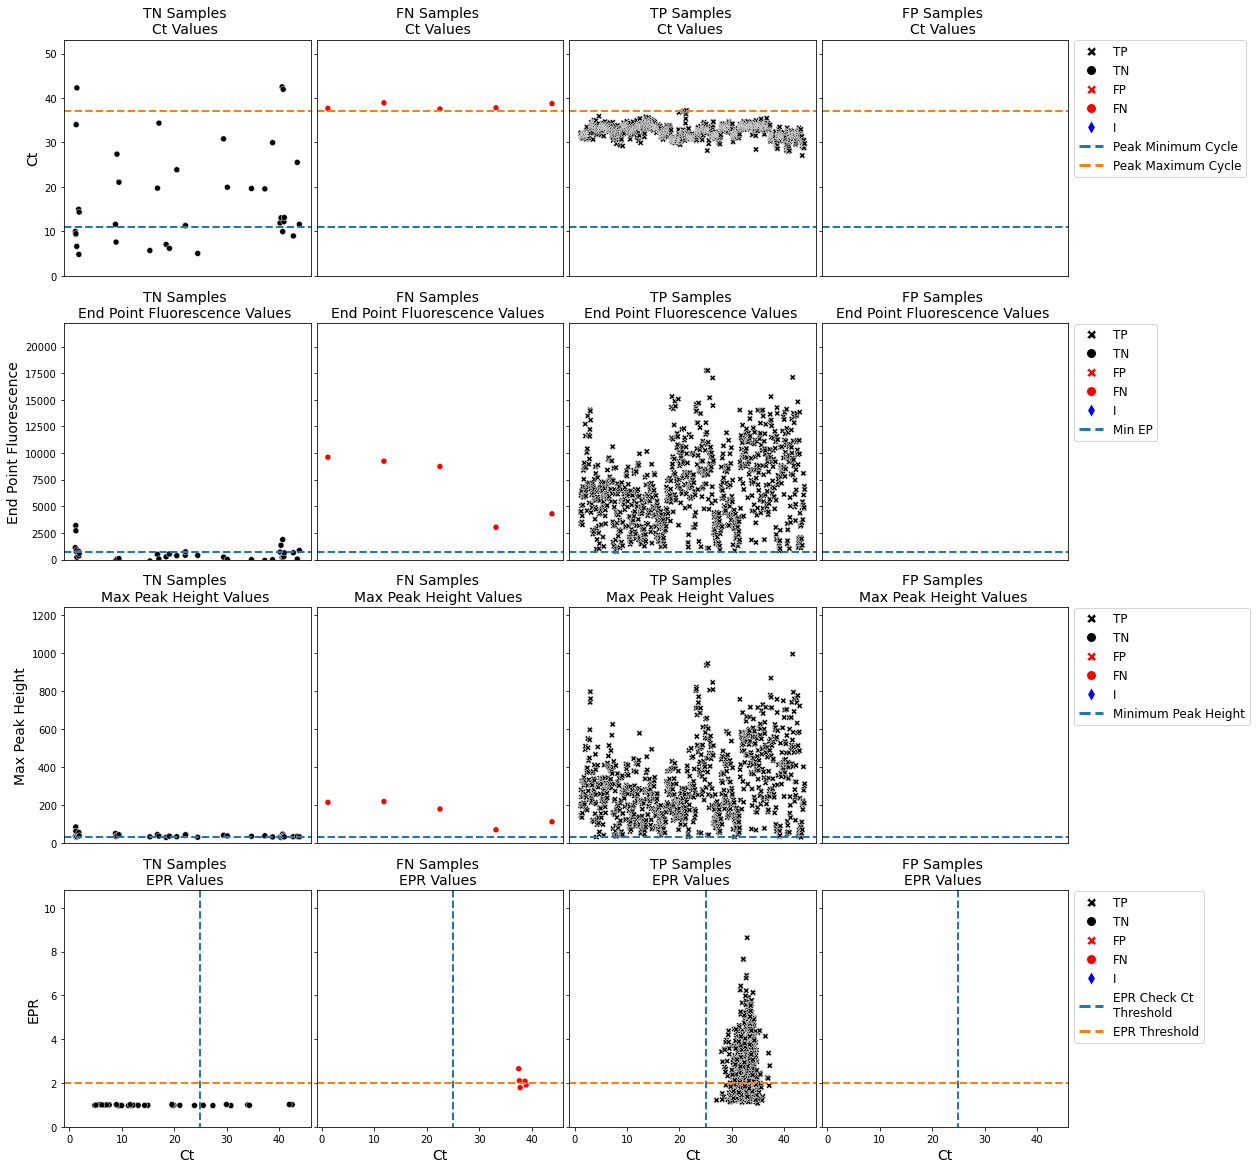

Processing FluB Target in TransportMedium Data


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


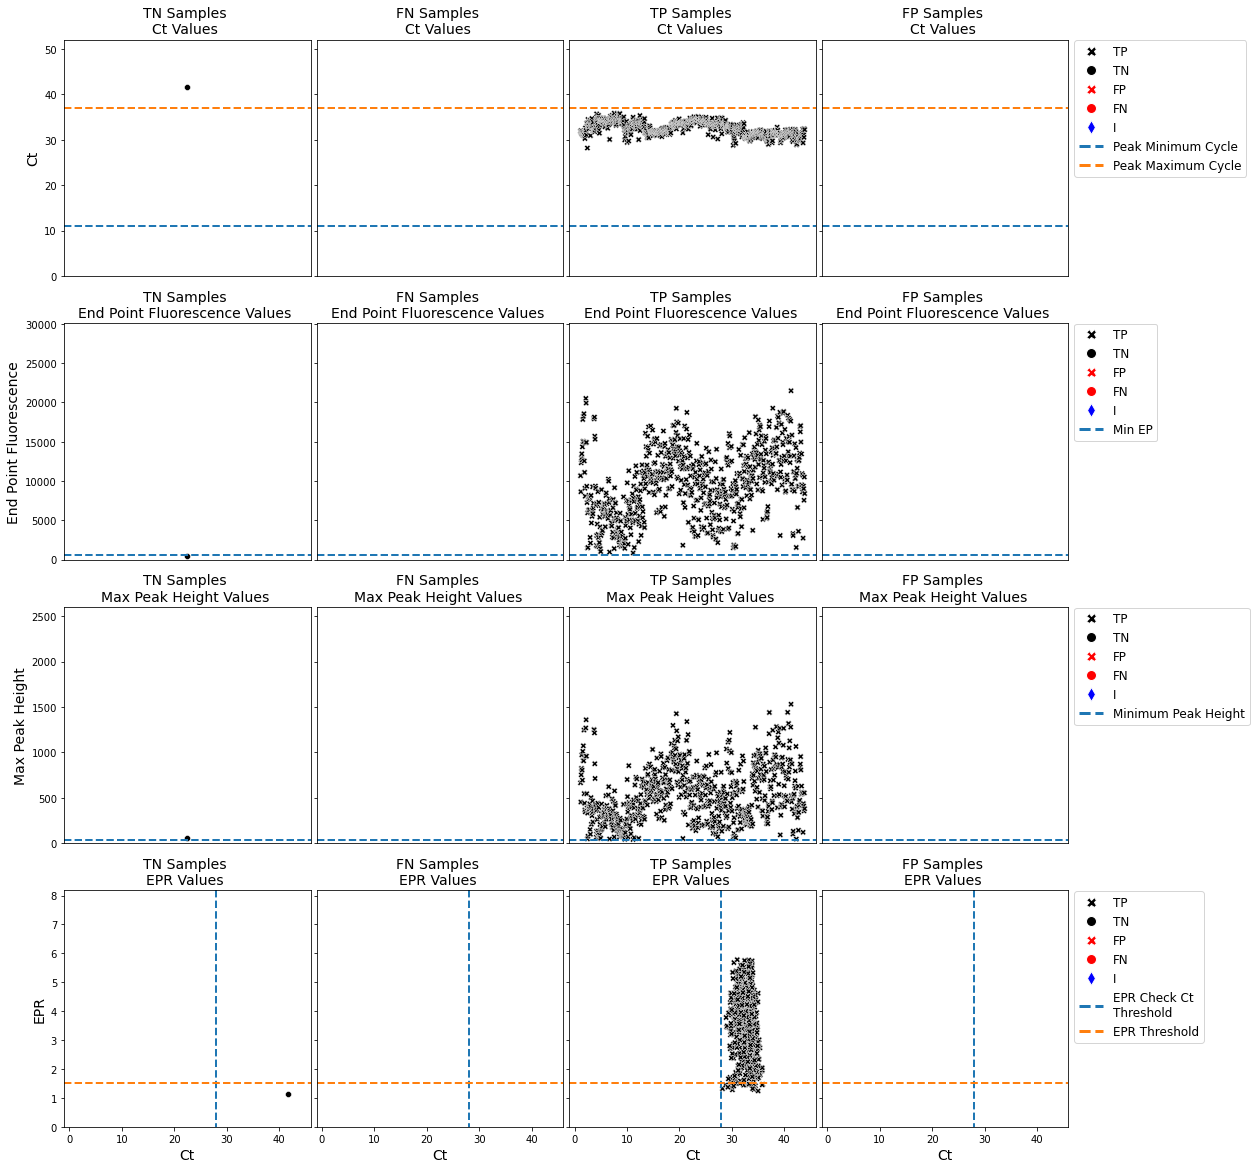

Processing SARS-CoV-2 Target in TransportMedium Data


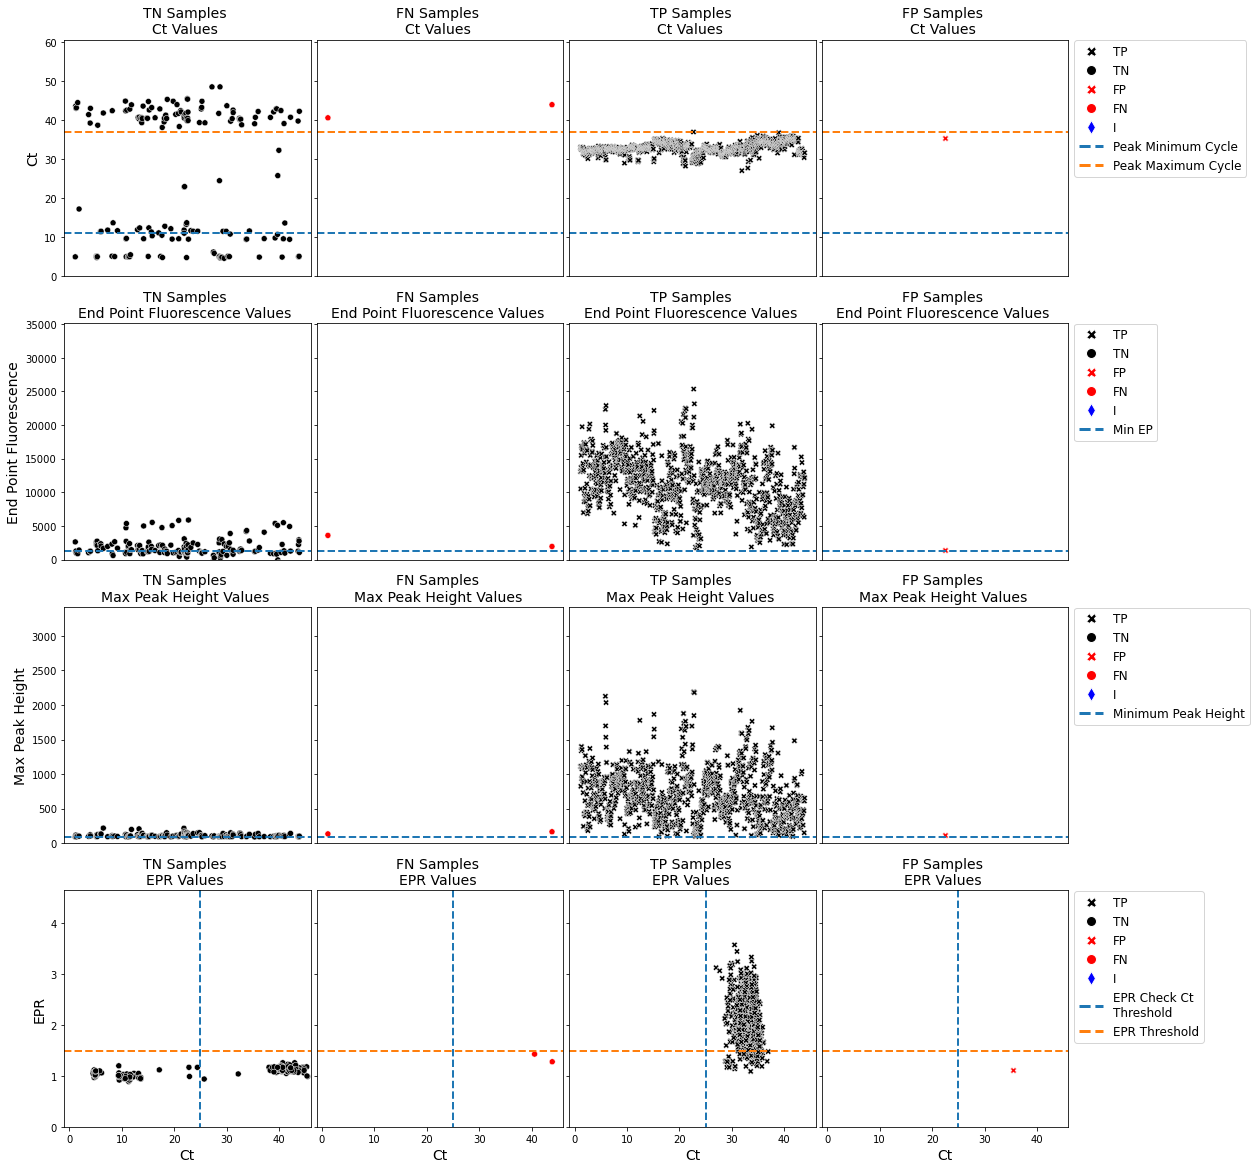

Processing RSV Target in TransportMedium Data


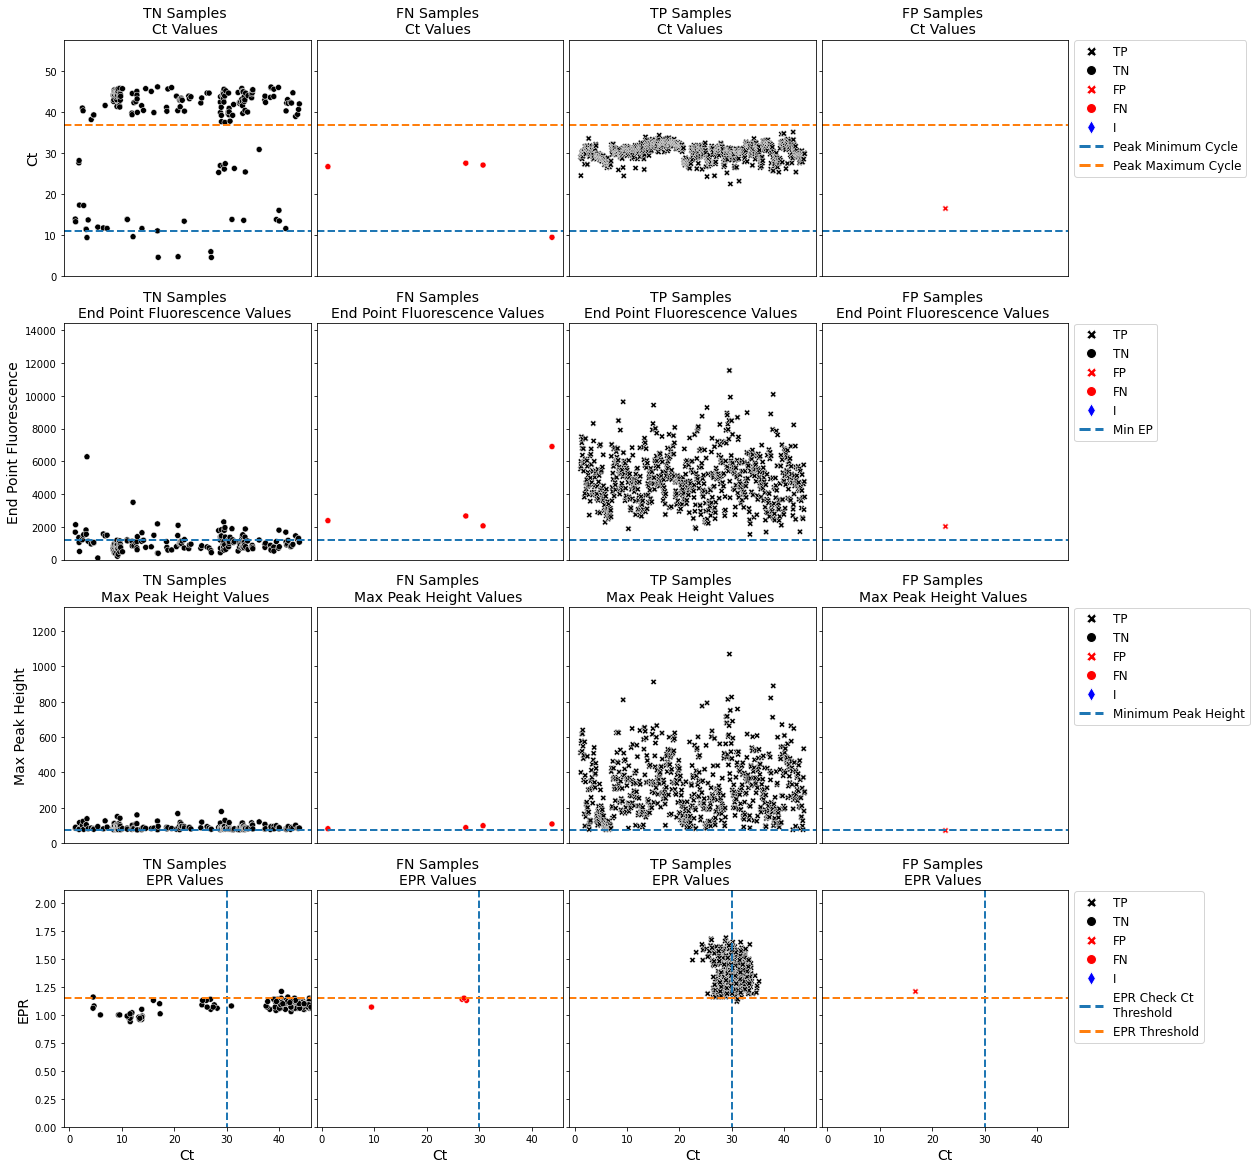

Processing SPC2 Target in TransportMedium Data


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


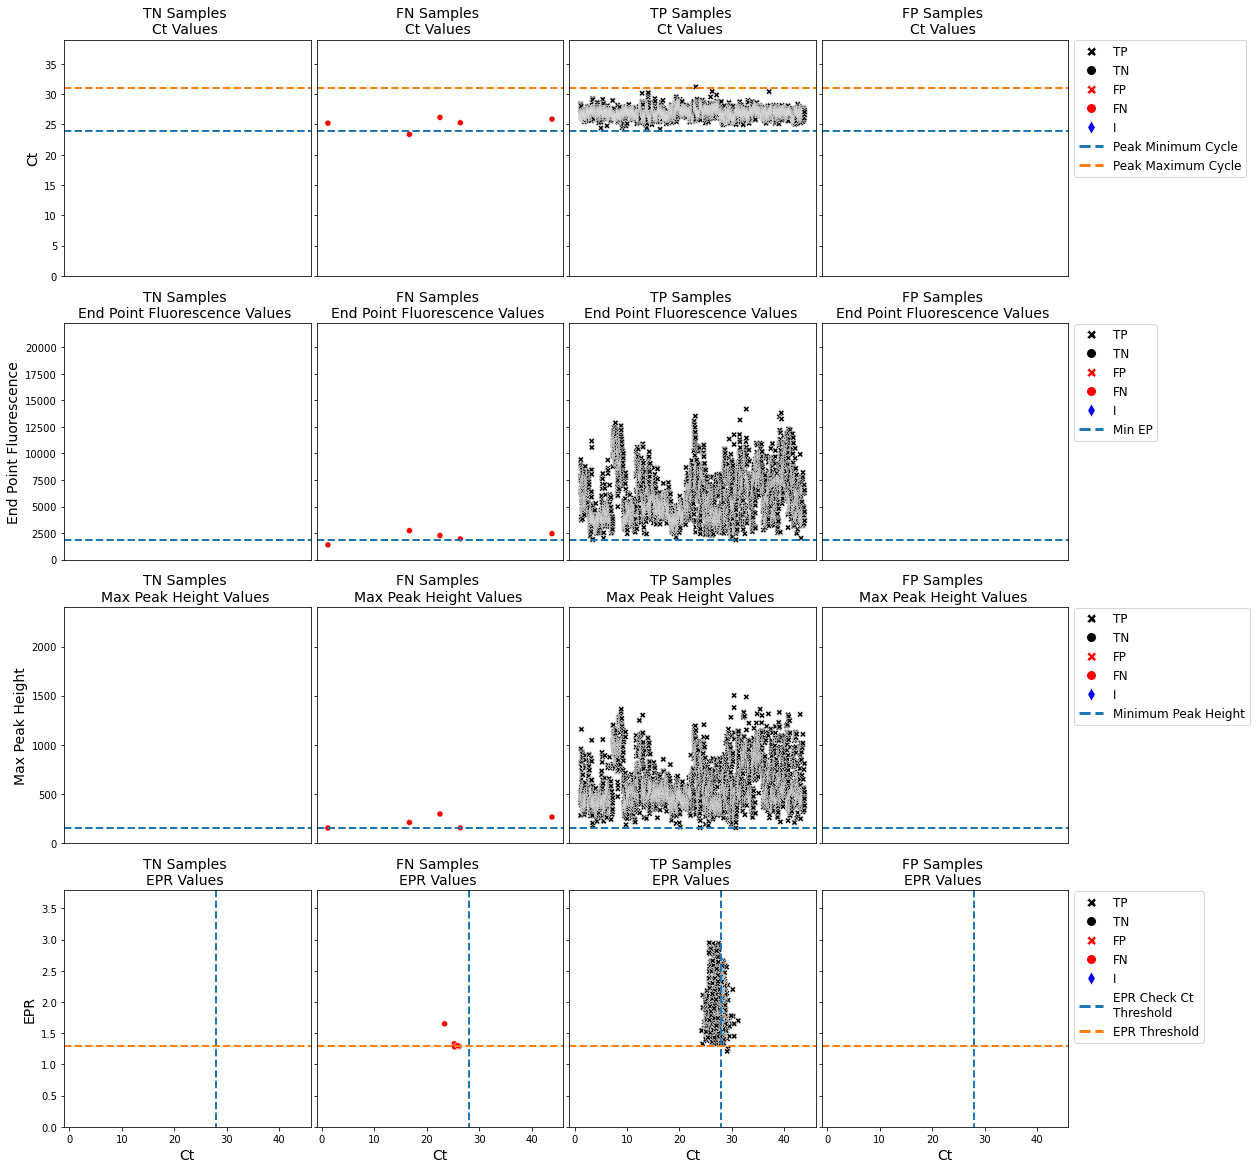

In [13]:
#Step 9: Generate "Cutoff Scatterplots" for each Channel in channels
targets = {'Green':'FluA','Yellow':'FluB','Orange':'SARS-CoV-2','Far Red':'RSV','Red':'SPC2'}
for channel in channels:
    print("Processing "+targets[channel]+" Target in TransportMedium Data")
    #Step 9A: Create Distribution Plots
    fig, axs = plt.subplots(4,4,figsize=(18,20),sharey='row')
    plt.subplots_adjust(wspace=0.025) 
    generateCutoffPlot(DataFrameFRS1_TransportMedium, channel, 'TransportMedium', '', 'Ct', [], ['Peak Minimum Cycle', 'Peak Maximum Cycle'], fig, 0)
    generateCutoffPlot(DataFrameFRS1_TransportMedium, channel, 'TransportMedium', '', 'End Point Fluorescence', [], ['Min EP'], fig, 1)
    generateCutoffPlot(DataFrameFRS1_TransportMedium, channel, 'TransportMedium', '', 'Max Peak Height', [], ['Minimum Peak Height'], fig, 2)
    generateCutoffPlot(DataFrameFRS1_TransportMedium, channel, 'TransportMedium', 'Ct', 'EPR', ['EPR Check Ct Threshold'], ['EPR Threshold'], fig, 3)
    plt.show()

In [69]:
##Step 10 Define Functions Necessary for ROC Analysis 
def doint(x, y):
    integral = np.trapz(y,x)
    return round(integral,3)

def performROCAnalysis(data, target, specType, analysis_param, adjustable_cutoff, adjustment_range_start, adjustment_range_end, adjustment_steps, show_output, show_curves):
    analysisData = data.loc[data[target+' Results Classification'].isin(['TP', 'TN', 'FP', 'FN'])]
    cutoffs = initialize_standard_cutoffs()
    
    ROC_Frame = pd.DataFrame(columns=['True Negatives',
                                      'True Positives',
                                      'False Negatives',
                                      'False Positives',
                                      'Analytical Sensitivity',
                                      'Analytical Specificity',
                                      '1 - Analytical Specificity',
                                      'Youden Index'])
                                      #'Parameter_mean',
                                      #'Parameter_std',
                                      #'Parameter_lcb',
                                      #'Parameter_ucb'])
    settings = np.linspace(adjustment_range_start,adjustment_range_end,adjustment_steps)
    for setting in settings:
        cutoffs[target][specType][adjustable_cutoff] = setting
        #print(cutoffs[target][specType][adjustable_cutoff], adjustable_cutoff)
        analysisData[target+'_Test_Target_Result'] = np.where((
                                                  (analysisData[target + ' Target Max Peak Height'].round(2)>cutoffs[target][specType]['Minimum Peak Height'])&
                                                  (analysisData[target + ' Target End Point Fluorescence'].round(2)>cutoffs[target][specType]['Min EP'])&
                                                  (analysisData[target+' Target Ct'].round(2)>=cutoffs[target][specType]['Peak Minimum Cycle'])&
                                                  (analysisData[target+' Target Ct'].round(2)<=(cutoffs[target][specType]['Peak Maximum Cycle'])+0.5)&
                                                  (analysisData[target+' Target EPR']>=cutoffs[target][specType]['Overall EPR Threshold'])&
                                                  (
                                                   (analysisData[target+' Target Ct']>=cutoffs[target][specType]['EPR Check Ct Threshold'])|
                                                   ((analysisData[target+' Target Ct']<=cutoffs[target][specType]['EPR Check Ct Threshold'])&(analysisData[target+' Target EPR'].round(2)>cutoffs[target][specType]['EPR Threshold']))
                                                  )),'AMP','NOTAMP')

        analysisData[target+'_Test_NMDX_Results_Classification'] = np.nan
        analysisData[target+'_Test_NMDX_Results_Classification'] = np.where(((analysisData[target+' Target Expected Result']=='NOTAMP')&
                                                                       (analysisData[target+'_Test_Target_Result']=='NOTAMP')),
                                                                       'TN',
                                                                       analysisData[target+'_Test_NMDX_Results_Classification'])


        analysisData[target+'_Test_NMDX_Results_Classification'] = np.where(((analysisData[target+' Target Expected Result']=='AMP')&
                                                                       (analysisData[target+'_Test_Target_Result']=='AMP')),
                                                                       'TP',
                                                                       analysisData[target+'_Test_NMDX_Results_Classification'])

        analysisData[target+'_Test_NMDX_Results_Classification'] = np.where(((analysisData[target+' Target Expected Result']=='AMP')&
                                                                       (analysisData[target+'_Test_Target_Result']=='NOTAMP')),
                                                                       'FN',
                                                                       analysisData[target+'_Test_NMDX_Results_Classification'])


        analysisData[target+'_Test_NMDX_Results_Classification'] = np.where(((analysisData[target+' Target Expected Result']=='NOTAMP')&
                                                                       (analysisData[target+'_Test_Target_Result']=='AMP')),
                                                                       'FP',
                                                                       analysisData[target+'_Test_NMDX_Results_Classification'])

        TN_count_test = len(analysisData[analysisData[target+'_Test_NMDX_Results_Classification']=='TN'])
        FN_count_test = len(analysisData[analysisData[target+'_Test_NMDX_Results_Classification']=='FN'])
        TP_count_test = len(analysisData[analysisData[target+'_Test_NMDX_Results_Classification']=='TP'])
        FP_count_test = len(analysisData[analysisData[target+'_Test_NMDX_Results_Classification']=='FP'])
        clin_sensitivity_test = (TP_count_test/(TP_count_test+FN_count_test))
        try:
            clin_specificity_test = (TN_count_test/(TN_count_test+FP_count_test))
        except ZeroDivisionError:
            clin_specificity_test = 1
        
        TP_param_mean = analysisData.loc[analysisData[target+'_Test_NMDX_Results_Classification']=='TP', target +" Target "+analysis_param].mean()
        TP_param_std = analysisData.loc[analysisData[target+'_Test_NMDX_Results_Classification']=='TP', target +" Target "+analysis_param].std()
        TP_param_lcb = TP_param_mean - (TP_param_std*2.325)
        TP_param_ucb = TP_param_mean + (TP_param_std*2.325)
        ROC_Frame.loc[setting, 'True Negatives'] = TN_count_test
        ROC_Frame.loc[setting, 'True Positives'] = TP_count_test
        ROC_Frame.loc[setting, 'False Negatives'] = FN_count_test
        ROC_Frame.loc[setting, 'False Positives'] = FP_count_test
        #ROC_Frame.loc[setting, 'Parameter_mean'] = TP_param_mean
        #ROC_Frame.loc[setting, 'Parameter_std'] = TP_param_std
        #ROC_Frame.loc[setting, 'Parameter_lcb'] = TP_param_lcb
        #ROC_Frame.loc[setting, 'Parameter_ucb'] = TP_param_ucb
        
        ROC_Frame.loc[setting, 'Analytical Sensitivity'] = clin_sensitivity_test
        ROC_Frame.loc[setting, 'Analytical Specificity'] = clin_specificity_test
    
    cutoffs = initialize_standard_cutoffs()
    
    
    ROC_Frame['1 - Analytical Specificity'] = 1-ROC_Frame['Analytical Specificity'] 
    ROC_Frame['Youden Index'] = ROC_Frame['Analytical Sensitivity'] + ROC_Frame['Analytical Specificity'] - 1
    
    
        
    
    if show_output == True:
        print("Results for", adjustable_cutoff, "Evaluation for", specType, target, "Target")
        print("Current Setting Is Optimal?: ", ROC_Frame['Youden Index'].max()==ROC_Frame.loc[cutoffs[target][specType][adjustable_cutoff], 'Youden Index'])
        print("Optimal Youden Index:", ROC_Frame['Youden Index'].max())
        print("Current Setting:", cutoffs[target][specType][adjustable_cutoff])
        print("Current Setting Youden Index:", ROC_Frame.loc[cutoffs[target][specType][adjustable_cutoff], 'Youden Index'])
        print("AUC", doint(np.append(ROC_Frame['1 - Analytical Specificity'],1), np.append(ROC_Frame['Analytical Sensitivity'].values,ROC_Frame['Analytical Sensitivity'].max())))
        display(HTML(ROC_Frame.sort_index().to_html()))
               

    if show_curves == True:
        if show_output == False:
            print("Results for", adjustable_cutoff, "Evaluation for", specType, target, "Target")
        fig, axs = plt.subplots(1,3,figsize=(20,5))
        axs[0].plot(ROC_Frame.index.values, ROC_Frame['Analytical Sensitivity'].values, 'o-')
        axs[0].plot(ROC_Frame.index.values, ROC_Frame['Analytical Specificity'].values, 'o-')
        axs[2].plot(ROC_Frame.index.values, ROC_Frame['Youden Index'].values, 'o-')
        ROC_Frame.sort_values(['1 - Analytical Specificity', 'Analytical Sensitivity'],inplace=True)

        ROC_X_Data = np.append(ROC_Frame['1 - Analytical Specificity'],1)
        ROC_Y_Data = np.append(ROC_Frame['Analytical Sensitivity'].values,ROC_Frame['Analytical Sensitivity'].max())
        ROC_X_Data = np.insert(ROC_X_Data,0,0)
        ROC_Y_Data = np.insert(ROC_Y_Data,0,0)
        axs[1].plot(ROC_X_Data, ROC_Y_Data, 'o-')
        axs[1].plot([0,1], [0,ROC_Frame['Analytical Sensitivity'].max()], 'o--',color='k')


        legend_elements = []

        labelsDict = {0:'Sensitivity',
                      1:'Specificity'}

        for i in range(0,2,1):
            newLabel = Line2D([0], [0], color=sns.color_palette()[i], lw=3, linestyle='-', label=labelsDict[i])
            legend_elements.append(newLabel)

        axs[0].legend(handles=legend_elements, loc='best')

        axs[0].set_title('Variation of Analytical Sensitivity / Specificity')
        axs[1].set_title('ROC Curve')
        axs[2].set_title('Youden Index')
        axs[0].set_xlabel(adjustable_cutoff+" Setting")
        axs[0].set_ylabel('Sensitivity/Specificity')
        axs[1].set_xlabel('1-Specificity (False Positive Rate)')
        axs[1].set_ylabel('Sensitivity (True Positive Rate)')
        axs[2].set_xlabel(adjustable_cutoff+" Setting")
        axs[2].set_ylabel('Youden Index (Sensitivity + Specificity - 1)')
        if adjustment_steps < 0:
            axs[0].invert_xaxis()

        plt.show()
    print("_ _ "*19)
    
    min_optimal_setting = ROC_Frame[ROC_Frame['Youden Index'] == ROC_Frame['Youden Index'].max()].index.min()
    max_optimal_setting = ROC_Frame[ROC_Frame['Youden Index'] == ROC_Frame['Youden Index'].max()].index.max()
    
    current_setting = cutoffs[target][specType][adjustable_cutoff]
    
    optimal_youden_index = ROC_Frame['Youden Index'].max()
    current_setting_youden_index = ROC_Frame.loc[cutoffs[target][specType][adjustable_cutoff], 'Youden Index']
    
    optimal_sens = ROC_Frame.loc[min_optimal_setting, 'Analytical Sensitivity']
    current_setting_sens = ROC_Frame.loc[cutoffs[target][specType][adjustable_cutoff], 'Analytical Sensitivity']
    
    optimal_spec = ROC_Frame.loc[min_optimal_setting, 'Analytical Specificity']
    current_setting_spec = ROC_Frame.loc[cutoffs[target][specType][adjustable_cutoff], 'Analytical Specificity']
    
    parameter = adjustable_cutoff
    RocSummaryFrame = pd.DataFrame(columns=['Current Setting',
                                           'Optimal Setting Range Start',
                                           'Optimal Setting Range End',
                                           'Current Setting Youden Index',
                                           'Optimal Youden Index',
                                           'Current Setting Analytical Sensitivity',
                                           'Optimal Analytical Sensitivity',
                                           'Current Setting Analytical Specificity',
                                           'Optimal Analytical Specificity'])
    
    RocSummaryFrame.loc[parameter] = [current_setting,
                                      min_optimal_setting,
                                      max_optimal_setting,
                                      current_setting_youden_index,
                                      optimal_youden_index,
                                      current_setting_sens,
                                      optimal_sens,
                                      current_setting_spec,
                                      optimal_spec
                                      ]
                                           
    return RocSummaryFrame

In [70]:
for channel in ['Orange']:
    show_raw_output=True
    show_summary_output=True
    show_curves_output=False
    dataset = DataFrameFRS1_TransportMedium
    specimen_type = 'TransportMedium'
    ROCAnalysisSummaryFrame = performROCAnalysis(dataset, channel, specimen_type,  'Ct', 'Peak Maximum Cycle', 1, 45, 45, show_raw_output, show_curves_output)            

    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'Ct', 'Peak Minimum Cycle', 1, 45, 45, show_raw_output, show_curves_output)])   
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'End Point Fluorescence', 'Min EP', 50, 2000, 40, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'Max Peak Height', 'Minimum Peak Height', 1, 150, 150, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'EPR', 'EPR Threshold', 0.05, 2.0, 40, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'Ct', 'EPR Check Ct Threshold', 1, 45, 45, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame['Optimal Youden Index?'] = np.where(ROCAnalysisSummaryFrame['Current Setting Youden Index'] == ROCAnalysisSummaryFrame['Optimal Youden Index'], 1.0, 0)
    ROCAnalysisSummaryFrame['Optimal Sensitivity?'] = np.where(ROCAnalysisSummaryFrame['Current Setting Analytical Sensitivity'] == ROCAnalysisSummaryFrame['Optimal Analytical Sensitivity'], 1, 0)
    ROCAnalysisSummaryFrame['Optimal Specificity?'] = np.where(ROCAnalysisSummaryFrame['Current Setting Analytical Specificity'] == ROCAnalysisSummaryFrame['Optimal Analytical Specificity'], 1, 0)
    if show_summary_output == True:
        print(channel+' '+targets[channel]+' ROC Analysis Summary for '+specimen_type)

        display(ROCAnalysisSummaryFrame.style.format('{:.1f}').format(subset=['Current Setting Youden Index',
                                                     'Optimal Youden Index',
                                                     'Current Setting Analytical Sensitivity',
                                                     'Optimal Analytical Sensitivity',
                                                     'Current Setting Analytical Specificity',
                                                     'Optimal Analytical Specificity'],formatter='{:.2%}').highlight_between(subset=[x for x in ROCAnalysisSummaryFrame.columns if '?' in x], color='green', left=0.9, right=1.1))

Results for Peak Maximum Cycle Evaluation for TransportMedium Green Target
Current Setting Is Optimal?:  False
Optimal Youden Index: 0.9958677685950414
Current Setting: 37
Current Setting Youden Index: 0.990702479338843
AUC 0.996


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,2661,0,968,0,0.0,1.0,0.0,0.0
2.0,2661,0,968,0,0.0,1.0,0.0,0.0
3.0,2661,0,968,0,0.0,1.0,0.0,0.0
4.0,2661,0,968,0,0.0,1.0,0.0,0.0
5.0,2661,0,968,0,0.0,1.0,0.0,0.0
6.0,2661,0,968,0,0.0,1.0,0.0,0.0
7.0,2661,0,968,0,0.0,1.0,0.0,0.0
8.0,2661,0,968,0,0.0,1.0,0.0,0.0
9.0,2661,0,968,0,0.0,1.0,0.0,0.0
10.0,2661,0,968,0,0.0,1.0,0.0,0.0


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for Peak Minimum Cycle Evaluation for TransportMedium Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.990702479338843
Current Setting: 11
Current Setting Youden Index: 0.990702479338843
AUC 0.495


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
2.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
3.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
4.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
5.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
6.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
7.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
8.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
9.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
10.0,2661,959,9,0,0.990702,1.0,0.0,0.990702


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for Min EP Evaluation for TransportMedium Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.990702479338843
Current Setting: 750
Current Setting Youden Index: 0.990702479338843
AUC 0.948


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
50.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
100.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
150.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
200.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
250.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
300.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
350.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
400.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
450.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
500.0,2661,959,9,0,0.990702,1.0,0.0,0.990702


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for Minimum Peak Height Evaluation for TransportMedium Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.990702479338843
Current Setting: 30
Current Setting Youden Index: 0.990702479338843
AUC 0.882


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
2.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
3.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
4.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
5.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
6.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
7.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
8.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
9.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
10.0,2661,959,9,0,0.990702,1.0,0.0,0.990702


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for EPR Threshold Evaluation for TransportMedium Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.990702479338843
Current Setting: 2.0
Current Setting Youden Index: 0.990702479338843
AUC 0.991


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
0.05,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.10,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.15,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.20,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.25,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.30,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.35,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.40,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.45,2661,959,9,0,0.990702,1.0,0.0,0.990702
0.50,2661,959,9,0,0.990702,1.0,0.0,0.990702


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for EPR Check Ct Threshold Evaluation for TransportMedium Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.990702479338843
Current Setting: 25
Current Setting Youden Index: 0.990702479338843
AUC 0.83


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
2.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
3.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
4.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
5.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
6.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
7.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
8.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
9.0,2661,959,9,0,0.990702,1.0,0.0,0.990702
10.0,2661,959,9,0,0.990702,1.0,0.0,0.990702


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Green FluA ROC Analysis Summary for TransportMedium


,Current Setting,Optimal Setting Range Start,Optimal Setting Range End,Current Setting Youden Index,Optimal Youden Index,Current Setting Analytical Sensitivity,Optimal Analytical Sensitivity,Current Setting Analytical Specificity,Optimal Analytical Specificity,Optimal Youden Index?,Optimal Sensitivity?,Optimal Specificity?
Peak Maximum Cycle,37.0,39.0,45.0,99.07%,99.59%,99.07%,99.59%,100.00%,100.00%,0.0,0.0,1.0
Peak Minimum Cycle,11.0,1.0,27.0,99.07%,99.07%,99.07%,99.07%,100.00%,100.00%,1.0,1.0,1.0
Min EP,750.0,50.0,750.0,99.07%,99.07%,99.07%,99.07%,100.00%,100.00%,1.0,1.0,1.0
Minimum Peak Height,30.0,1.0,31.0,99.07%,99.07%,99.07%,99.07%,100.00%,100.00%,1.0,1.0,1.0
EPR Threshold,2.0,0.1,2.0,99.07%,99.07%,99.07%,99.07%,100.00%,100.00%,1.0,1.0,1.0
EPR Check Ct Threshold,25.0,1.0,27.0,99.07%,99.07%,99.07%,99.07%,100.00%,100.00%,1.0,1.0,1.0


In [55]:
for channel in ['Green','Yellow','Orange','Far Red','Red']:
    show_raw_output=False
    show_summary_output=True  
    show_curves_output=False
    dataset = DataFrameFRS1_UserSpecified1
    specimen_type = 'UserSpecified1'
    ROCAnalysisSummaryFrame = performROCAnalysis(dataset, channel, specimen_type,  'Ct', 'Peak Maximum Cycle', 1, 45, 45, show_raw_output, show_curves_output)            

    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'Ct', 'Peak Minimum Cycle', 1, 45, 45, show_raw_output, show_curves_output)])   
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'End Point Fluorescence', 'Min EP', 50, 2000, 40, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'Max Peak Height', 'Minimum Peak Height', 1, 150, 150, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'EPR', 'EPR Threshold', 0.05, 2.0, 40, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame = pd.concat([ROCAnalysisSummaryFrame, performROCAnalysis(dataset, channel, specimen_type,  'Ct', 'EPR Check Ct Threshold', 1, 45, 45, show_raw_output, show_curves_output)])
    ROCAnalysisSummaryFrame['Optimal Youden Index?'] = np.where(ROCAnalysisSummaryFrame['Current Setting Youden Index'] == ROCAnalysisSummaryFrame['Optimal Youden Index'], 1.0, 0)
    ROCAnalysisSummaryFrame['Optimal Sensitivity?'] = np.where(ROCAnalysisSummaryFrame['Current Setting Analytical Sensitivity'] == ROCAnalysisSummaryFrame['Optimal Analytical Sensitivity'], 1, 0)
    ROCAnalysisSummaryFrame['Optimal Specificity?'] = np.where(ROCAnalysisSummaryFrame['Current Setting Analytical Specificity'] == ROCAnalysisSummaryFrame['Optimal Analytical Specificity'], 1, 0)
    if show_summary_output == True:
        print(channel+' '+targets[channel]+' ROC Analysis Summary for '+specimen_type)

        display(ROCAnalysisSummaryFrame.style.format('{:.1f}').format(subset=['Current Setting Youden Index',
                                                     'Optimal Youden Index',
                                                     'Current Setting Analytical Sensitivity',
                                                     'Optimal Analytical Sensitivity',
                                                     'Current Setting Analytical Specificity',
                                                     'Optimal Analytical Specificity'],formatter='{:.2%}').highlight_between(subset=[x for x in ROCAnalysisSummaryFrame.columns if '?' in x], color='green', left=0.9, right=1.1))

Results for Peak Maximum Cycle Evaluation for UserSpecified1 Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.9931389365351628
Current Setting: 37
Current Setting Youden Index: 0.9931389365351628
AUC 0.993


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,1214,0,583,0,0.0,1.0,0.0,0.0
2.0,1214,0,583,0,0.0,1.0,0.0,0.0
3.0,1214,0,583,0,0.0,1.0,0.0,0.0
4.0,1214,0,583,0,0.0,1.0,0.0,0.0
5.0,1214,0,583,0,0.0,1.0,0.0,0.0
6.0,1214,0,583,0,0.0,1.0,0.0,0.0
7.0,1214,0,583,0,0.0,1.0,0.0,0.0
8.0,1214,0,583,0,0.0,1.0,0.0,0.0
9.0,1214,0,583,0,0.0,1.0,0.0,0.0
10.0,1214,0,583,0,0.0,1.0,0.0,0.0


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for Peak Minimum Cycle Evaluation for UserSpecified1 Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.9931389365351628
Current Setting: 11
Current Setting Youden Index: 0.9931389365351628
AUC 0.497


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
2.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
3.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
4.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
5.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
6.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
7.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
8.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
9.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
10.0,1214,579,4,0,0.993139,1.0,0.0,0.993139


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for Min EP Evaluation for UserSpecified1 Green Target
Current Setting Is Optimal?:  False
Optimal Youden Index: 0.9948542024013722
Current Setting: 750
Current Setting Youden Index: 0.9931389365351628
AUC 0.987


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
50.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
100.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
150.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
200.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
250.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
300.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
350.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
400.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
450.0,1214,580,3,0,0.994854,1.0,0.0,0.994854
500.0,1214,580,3,0,0.994854,1.0,0.0,0.994854


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for Minimum Peak Height Evaluation for UserSpecified1 Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.9931389365351628
Current Setting: 30
Current Setting Youden Index: 0.9931389365351628
AUC 0.947


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
2.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
3.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
4.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
5.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
6.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
7.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
8.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
9.0,1214,579,4,0,0.993139,1.0,0.0,0.993139
10.0,1214,579,4,0,0.993139,1.0,0.0,0.993139


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for EPR Threshold Evaluation for UserSpecified1 Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.9931389365351628
Current Setting: 2.0
Current Setting Youden Index: 0.9931389365351628
AUC 0.992


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
0.05,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.10,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.15,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.20,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.25,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.30,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.35,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.40,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.45,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
0.50,1213,579,4,1,0.993139,0.999176,0.000824,0.992315


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Results for EPR Check Ct Threshold Evaluation for UserSpecified1 Green Target
Current Setting Is Optimal?:  True
Optimal Youden Index: 0.9931389365351628
Current Setting: 25
Current Setting Youden Index: 0.9931389365351628
AUC 0.897


,True Negatives,True Positives,False Negatives,False Positives,Analytical Sensitivity,Analytical Specificity,1 - Analytical Specificity,Youden Index
1.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
2.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
3.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
4.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
5.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
6.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
7.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
8.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
9.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315
10.0,1213,579,4,1,0.993139,0.999176,0.000824,0.992315


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Green FluA ROC Analysis Summary for UserSpecified1


,Current Setting,Optimal Setting Range Start,Optimal Setting Range End,Current Setting Youden Index,Optimal Youden Index,Current Setting Analytical Sensitivity,Optimal Analytical Sensitivity,Current Setting Analytical Specificity,Optimal Analytical Specificity,Optimal Youden Index?,Optimal Sensitivity?,Optimal Specificity?
Peak Maximum Cycle,37.0,35.0,45.0,99.31%,99.31%,99.31%,99.31%,100.00%,100.00%,1.0,1.0,1.0
Peak Minimum Cycle,11.0,1.0,28.0,99.31%,99.31%,99.31%,99.31%,100.00%,100.00%,1.0,1.0,1.0
Min EP,750.0,50.0,600.0,99.31%,99.49%,99.31%,99.49%,100.00%,100.00%,0.0,0.0,1.0
Minimum Peak Height,30.0,1.0,32.0,99.31%,99.31%,99.31%,99.31%,100.00%,100.00%,1.0,1.0,1.0
EPR Threshold,2.0,1.0,2.0,99.31%,99.31%,99.31%,99.31%,100.00%,100.00%,1.0,1.0,1.0
EPR Check Ct Threshold,25.0,12.0,28.0,99.31%,99.31%,99.31%,99.31%,100.00%,100.00%,1.0,1.0,1.0


In [57]:
DataFrameFRS1_TransportMedium.loc[DataFrameFRS1_TransportMedium['Far Red Results Classification']=='FP']

,,,,,Far_Red Target Ct,Far_Red Target End Point Fluorescence,Far_Red Target Max Peak Height,Far_Red Target EPR,Far_Red Target Localized Result,Far_Red Target File Source,Far_Red Target Readings 1,Far_Red Target Readings 2,Far_Red Target Readings 3,Far_Red Target Readings 4,...,Yellow Results Classification II,Orange Results Classification,Orange Results Classification I,Orange Results Classification II,Far_Red Results Classification,Far_Red Results Classification I,Far_Red Results Classification II,Red Results Classification,Red Results Classification I,Red Results Classification II
Processing Step,Assay Version,Test Guid,Sample ID,Start Time,,,,,,,,,,,,,,,,,,,,,


In [46]:
DataFrameFRS1_UserSpecified1.loc[DataFrameFRS1_UserSpecified1['Orange Results Classification']=='FP']

,,,,,Far_Red Target Ct,Far_Red Target End Point Fluorescence,Far_Red Target Max Peak Height,Far_Red Target EPR,Far_Red Target Localized Result,Far_Red Target File Source,Far_Red Target Readings 1,Far_Red Target Readings 2,Far_Red Target Readings 3,Far_Red Target Readings 4,...,Yellow Results Classification II,Orange Results Classification,Orange Results Classification I,Orange Results Classification II,Far_Red Results Classification,Far_Red Results Classification I,Far_Red Results Classification II,Red Results Classification,Red Results Classification I,Red Results Classification II
Processing Step,Assay Version,Test Guid,Sample ID,Start Time,,,,,,,,,,,,,,,,,,,,,
Raw,2.1.1,94ca8576-277a-ec11-85c8-d89ef338f2b8,DI2117,2021-09-14 08:16:11.080,33.349998,5358.0,290.980011,1.31,AMP,P:/ASSAY/AlexL/4-plex cutoff verification/\Raw...,15577.0,15479.0,15436.0,15405.0,...,N,FP,F,P,TP,T,P,TP,T,P


In [47]:
DataFrameFRS1_UserSpecified1.loc[DataFrameFRS1_UserSpecified1['Orange Results Classification']=='FP']

,,,,,Far_Red Target Ct,Far_Red Target End Point Fluorescence,Far_Red Target Max Peak Height,Far_Red Target EPR,Far_Red Target Localized Result,Far_Red Target File Source,Far_Red Target Readings 1,Far_Red Target Readings 2,Far_Red Target Readings 3,Far_Red Target Readings 4,...,Yellow Results Classification II,Orange Results Classification,Orange Results Classification I,Orange Results Classification II,Far_Red Results Classification,Far_Red Results Classification I,Far_Red Results Classification II,Red Results Classification,Red Results Classification I,Red Results Classification II
Processing Step,Assay Version,Test Guid,Sample ID,Start Time,,,,,,,,,,,,,,,,,,,,,


In [48]:
DataFrameFRS1_UserSpecified1.loc[DataFrameFRS1_UserSpecified1['Far_Red Results Classification']=='FP']

,,,,,Far_Red Target Ct,Far_Red Target End Point Fluorescence,Far_Red Target Max Peak Height,Far_Red Target EPR,Far_Red Target Localized Result,Far_Red Target File Source,Far_Red Target Readings 1,Far_Red Target Readings 2,Far_Red Target Readings 3,Far_Red Target Readings 4,...,Yellow Results Classification II,Orange Results Classification,Orange Results Classification I,Orange Results Classification II,Far_Red Results Classification,Far_Red Results Classification I,Far_Red Results Classification II,Red Results Classification,Red Results Classification I,Red Results Classification II
Processing Step,Assay Version,Test Guid,Sample ID,Start Time,,,,,,,,,,,,,,,,,,,,,


In [58]:
[x for x in DataFrameFRS1_TransportMedium.columns if "Expected" in x]

['Green Target Expected Result',
 'Yellow Target Expected Result',
 'Orange Target Expected Result',
 'Far_Red Target Expected Result',
 'Red Target Expected Result']

In [64]:
DataFrameFRS1_TransportMedium.loc[((DataFrameFRS1_TransportMedium['Green Target Expected Result']=='NOTAMP') & (DataFrameFRS1_TransportMedium['Green Target Ct']>30)),[x for x in DataFrameFRS1_TransportMedium.columns if "Green" in x]]

Green Target Ct  \
Processing Step Assay Version Test Guid                            Sample ID         Start Time                                 
Raw             2.1.1         03243152-f785-ec11-85ca-d89ef338f2b8 BM9005            2021-10-18 14:11:28.837        34.009998   
                              24ff5358-f785-ec11-85ca-d89ef338f2b8 BM9007            2021-10-18 14:17:34.610        42.270000   
                              38d8c852-ec7e-ec11-86b9-1866da4c156d FRSNC11607X221104 2022-01-18 19:19:27.250        34.349998   
                              8819bd95-117a-ec11-85c8-d89ef338f2b8 MV0812            2021-11-08 16:02:27.993        30.820000   
                              715d9b60-f885-ec11-85ca-d89ef338f2b8 SE9024            2021-10-28 09:46:11.263        42.500000   
                              0ab69f0e-f985-ec11-85ca-d89ef338f2b8 SF9010            2021-10-29 10:53:31.933        41.950001   

                                                                                                              Green Target End Point Fluorescence  \
Processing Step Assay Version Test Guid                            Sample ID         Start Time                                                     
Raw             2.1.1         03243152-f785-ec11-85ca-d89ef338f2b8 BM9005            2021-10-18 14:11:28.837                                772.0   
                              24ff5358-f785-ec11-85ca-d89ef338f2b8 BM9007            2021-10-18 14:17:34.610                                221.0   
                              38d8c852-ec7e-ec11-86b9-1866da4c156d FRSNC11607X221104 2022-01-18 19:19:27.250                                 58.0   
                              8819bd95-117a-ec11-85c8-d89ef338f2b8 MV0812            2021-11-08 16:02:27.993                                232.0   
                              715d9b60-f885-ec11-85ca-d89ef338f2b8 SE9024            2021-10-28 09:46:11.263                                213.0   
                              0ab69f0e-f985-ec11-85ca-d89ef338f2b8 SF9010            2021-10-29 10:53:31.933                                209.0   

                                                                                                              Green Target Max Peak Height  \
Processing Step Assay Version Test Guid                            Sample ID         Start Time                                              
Raw             2.1.1         03243152-f785-ec11-85ca-d89ef338f2b8 BM9005            2021-10-18 14:11:28.837                     31.799999   
                              24ff5358-f785-ec11-85ca-d89ef338f2b8 BM9007            2021-10-18 14:17:34.610                     34.680000   
                              38d8c852-ec7e-ec11-86b9-1866da4c156d FRSNC11607X221104 2022-01-18 19:19:27.250                     37.139999   
                              8819bd95-117a-ec11-85c8-d89ef338f2b8 MV0812            2021-11-08 16:02:27.993                     41.619999   
                              715d9b60-f885-ec11-85ca-d89ef338f2b8 SE9024            2021-10-28 09:46:11.263                     35.240002   
                              0ab69f0e-f985-ec11-85ca-d89ef338f2b8 SF9010            2021-10-29 10:53:31.933                     37.820000   

                                                                                                              Green Target EPR  \
Processing Step Assay Version Test Guid                            Sample ID         Start Time                                  
Raw             2.1.1         03243152-f785-ec11-85ca-d89ef338f2b8 BM9005            2021-10-18 14:11:28.837              1.00   
                              24ff5358-f785-ec11-85ca-d89ef338f2b8 BM9007            2021-10-18 14:17:34.610              1.01   
                              38d8c852-ec7e-ec11-86b9-1866da4c156d FRSNC11607X221104 2022-01-18 19:19:27.250              0.98   
                              8819bd95-117a-ec11-85c8-d89ef338f2b8 MV0812            2021-11-08 1